In [5]:
# Import Library
from operator import index
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
import os
import codecs, json
import tempfile
import requests
import base64
import csv
import numpy as np
np.set_printoptions(precision=4)
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
#from pydantic_settings import BaseSettings
import pandas_profiling
#from pivottablejs import pivot_ui
import webbrowser
import plotly.express as px
from bokeh.plotting import figure, show, output_notebook,output_file
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider, HoverTool
from bokeh.palettes import Spectral4
from bokeh.io import push_notebook
from bokeh.models import Range1d
output_notebook()
from ipywidgets import interact

Loading BokehJS ...

In [6]:
# Read Data
df = pd.read_csv('results.csv', low_memory=False, encoding='latin1')
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113 entries, 0 to 11112
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    11113 non-null  object 
 1   DateTime  11113 non-null  object 
 2   HomeTeam  11113 non-null  object 
 3   AwayTeam  11113 non-null  object 
 4   FTHG      11113 non-null  int64  
 5   FTAG      11113 non-null  int64  
 6   FTR       11113 non-null  object 
 7   HTHG      10189 non-null  float64
 8   HTAG      10189 non-null  float64
 9   HTR       10189 non-null  object 
 10  Referee   8289 non-null   object 
 11  HS        8289 non-null   float64
 12  AS        8289 non-null   float64
 13  HST       8289 non-null   float64
 14  AST       8289 non-null   float64
 15  HC        8289 non-null   float64
 16  AC        8289 non-null   float64
 17  HF        8289 non-null   float64
 18  AF        8289 non-null   float64
 19  HY        8289 non-null   float64
 20  AY        8289 non-null   fl

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
9311,2017-18,2017-08-27T00:00:00Z,Liverpool,Arsenal,4,0,H,2.0,0.0,H,...,10.0,0.0,4.0,3.0,6.0,9.0,2.0,4.0,0.0,0.0
5340,2006-07,2007-01-21T00:00:00Z,Arsenal,Man United,2,1,H,0.0,0.0,D,...,11.0,6.0,8.0,6.0,13.0,11.0,1.0,3.0,0.0,0.0
11107,2021-22,2022-04-09T15:00:00Z,Watford,Leeds,0,3,A,0.0,1.0,A,...,1.0,5.0,3.0,8.0,8.0,12.0,2.0,0.0,0.0,0.0
4140,2003-04,2003-12-26T00:00:00Z,Man United,Everton,3,2,H,2.0,1.0,H,...,11.0,6.0,7.0,2.0,8.0,10.0,0.0,2.0,0.0,0.0
3610,2002-03,2002-08-28T00:00:00Z,Southampton,Chelsea,1,1,D,0.0,0.0,D,...,4.0,3.0,5.0,6.0,16.0,11.0,2.0,1.0,0.0,0.0


In [7]:
# Convert Date into Day
df["matchDate"] = pd.to_datetime(df["DateTime"], infer_datetime_format=True)
df['matchDay'] = df['matchDate'].dt.day_name()
print(df["matchDate"][0])
print(df['matchDay'][149])
df.drop('DateTime', axis=1, inplace=True)
df.drop('matchDate', axis=1, inplace=True)
df.head()

df.matchDay.value_counts()

1993-08-14 00:00:00+00:00
Saturday


matchDay
Saturday     6394
Sunday       2185
Wednesday     993
Monday        738
Tuesday       558
Friday        129
Thursday      116
Name: count, dtype: int64

In [8]:
# Function to visualize the features with missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis = 1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {
        0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n' 'There are ' + str(
        mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataframe has 23 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values,type
Referee,2824,25.4,object
HS,2824,25.4,float64
AS,2824,25.4,float64
HST,2824,25.4,float64
AST,2824,25.4,float64
HC,2824,25.4,float64
AC,2824,25.4,float64
HF,2824,25.4,float64
AF,2824,25.4,float64
HY,2824,25.4,float64


In [9]:
# drop missing row
df = df.dropna().reset_index(drop=True)

# drop referee
df.drop('Referee', axis=1, inplace=True)

missing_values_table(df)

df.Season.value_counts()

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.


Season
2000-01    380
2001-02    380
2020-21    380
2019-20    380
2018-19    380
2017-18    380
2016-17    380
2015-16    380
2014-15    380
2013-14    380
2012-13    380
2011-12    380
2010-11    380
2009-10    380
2008-09    380
2007-08    380
2006-07    380
2005-06    380
2004-05    380
2003-04    380
2002-03    380
2021-22    309
Name: count, dtype: int64

In [10]:
# convert Season to num
df['Season'] = df['Season'].str[-2:].astype('int')

# convert FTR and HTR to int
df['FTR'] = df['FTR'].map(
    {'H': 1, 'A': -1, 'D': 0})

df['HTR'] = df['HTR'].map(
    {'H': 1, 'A': -1, 'D': 0})

In [11]:
# add feature comeback
def comeback(HT, FT):
    if HT == -1 and FT == 1:
        return 1
    elif HT == 1 and FT == -1:
        return -1
    else:
        return 0
df['comeback'] = df.apply(lambda row: comeback(row.HTR, row.FTR), axis = 1)
df['comeback2']=np.where((df['FTR']!=df['HTR'])&(df['FTR']!='D') & (df['HTR']!='D'),1,0)


In [15]:
# split dftrain and testing
df_train = df[df.Season <21]
df_test = df[df.Season == 21]

In [29]:
df_train.groupby('HomeTeam')

In [30]:
## CREATE HAS HAC AAS AAC
home_stat = df_train.groupby('HomeTeam').sum()
away_stat = df_train.groupby('AwayTeam').sum()


home_stat['HAS'] = home_stat['FTHG']
home_stat['HAC'] = home_stat['FTAG']
away_stat['AAS'] = away_stat['FTAG']
away_stat['AAC'] = away_stat['FTHG']

team_stat = pd.DataFrame()
team_stat['Team'] = home_stat.index
team_stat

team_stat = team_stat.merge(home_stat['HAS'], left_on='Team', right_index=True)
team_stat = team_stat.merge(home_stat['HAC'], left_on='Team', right_index=True)

team_stat = team_stat.merge(away_stat['AAS'], left_on='Team', right_index=True)
team_stat = team_stat.merge(away_stat['AAC'], left_on='Team', right_index=True)

from sklearn.preprocessing import MinMaxScaler
team_stat.set_index("Team", inplace=True)
scaler = MinMaxScaler()
team_stat = pd.DataFrame(scaler.fit_transform(team_stat), columns=team_stat.columns, index=team_stat.index)

col_list = ['HomeTeam', 'AwayTeam', 'FTR', 'matchDay', 'comeback','Season']
new_df = df[col_list]

In [31]:
## CREATE HWP HLP HCP AWP ALP ACP
home_win=round((df_train.loc[df_train['FTR']==1].groupby('HomeTeam')['FTR'].count()/df_train.groupby('HomeTeam')['FTR'].count()),3)
home_loss=round((df_train.loc[df_train['FTR']==-1].groupby('HomeTeam')['FTR'].count()/df_train.groupby('HomeTeam')['FTR'].count()),3)
home_draw=round((df_train.loc[df_train['FTR']==0].groupby('HomeTeam')['FTR'].count()/df_train.groupby('HomeTeam')['FTR'].count()),3)
home_cb = df_train.loc[(df_train['comeback']==1)].groupby('HomeTeam')['comeback2'].sum()
away_win=round((df_train.loc[df_train['FTR']==-1].groupby('AwayTeam')['FTR'].count()/df_train.groupby('AwayTeam')['FTR'].count()),3)
away_loss=round((df_train.loc[df_train['FTR']==1].groupby('AwayTeam')['FTR'].count()/df_train.groupby('AwayTeam')['FTR'].count()),3)
away_draw=round((df_train.loc[df_train['FTR']==0].groupby('AwayTeam')['FTR'].count()/df_train.groupby('AwayTeam')['FTR'].count()),3)
away_cb = df_train.loc[(df_train['comeback']==-1)].groupby('AwayTeam')['comeback2'].sum()

home_stat['HWP'] = home_win
home_stat['HLP'] = home_loss
home_stat['HDP'] = home_draw
home_stat['HCP'] = home_cb
away_stat['AWP'] = away_win
away_stat['ALP'] = away_loss
away_stat['ADP'] = away_draw
away_stat['ACP'] = away_cb

team_stat = team_stat.merge(home_stat['HWP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(home_stat['HLP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(home_stat['HDP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(home_stat['HCP'], left_on='Team', right_index=True)

team_stat = team_stat.merge(away_stat['AWP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(away_stat['ALP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(away_stat['ADP'], left_on='Team', right_index=True)
team_stat = team_stat.merge(away_stat['ACP'], left_on='Team', right_index=True)


In [32]:
# Missing Values: 10 in ACP, 6 in ACP. Replace with 0
team_stat = team_stat.fillna(0)

In [33]:
# Model Predicting
# newdf
new_df = new_df.merge(team_stat['HAS'], left_on='HomeTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['HAC'], left_on='HomeTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['AAS'], left_on='AwayTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['AAC'], left_on='AwayTeam', right_index=True, how='left')

new_df['Hstr'] = (new_df['HAS'] * new_df['AAC']); # Home Attack Strength
new_df['Astr'] = (new_df['HAC'] * new_df['AAS']); # Away Attack Strength

new_df = new_df.merge(team_stat['HWP'], left_on='HomeTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['HLP'], left_on='HomeTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['HDP'], left_on='HomeTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['HCP'], left_on='HomeTeam', right_index=True, how='left')

new_df = new_df.merge(team_stat['AWP'], left_on='AwayTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['ALP'], left_on='AwayTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['ADP'], left_on='AwayTeam', right_index=True, how='left')
new_df = new_df.merge(team_stat['ACP'], left_on='AwayTeam', right_index=True, how='left')


In [34]:
# Brentford isi 0
new_df = new_df.fillna(0)

In [35]:
# SPLIT Training dan Testing
new_df = pd.get_dummies(new_df, columns=['matchDay'], prefix = ['matchDay'])

new_df_train = new_df[new_df.Season < 21]
new_df_test = new_df[new_df.Season == 21]

X_train = new_df_train.drop(['HomeTeam','AwayTeam','FTR'], axis=1)
y_train = new_df_train['FTR']
X_test = new_df_test.drop(['HomeTeam','AwayTeam','FTR'], axis=1)
y_test = new_df_test['FTR']


In [36]:
# 1. Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
acc_score = accuracy_score(y_test, rfc_pred)
print("Accuracy score: " + str(acc_score))
scores = cross_val_score(rfc, X_train, y_train, cv=10)
print("Cross val scores")
print(scores)

score_train = rfc.score(X_train, y_train)
score_test = rfc.score(X_test, y_test)

print("Training set accuracy: ", '%.6f'%(score_train))
print("Test set accuracy: ", '%.6f'%(score_test))

Accuracy score: 0.43157894736842106
Cross val scores
[0.4447 0.4184 0.4711 0.4355 0.4461 0.4697 0.4474 0.4566 0.4461 0.5092]
Training set accuracy:  1.000000
Test set accuracy:  0.431579


In [37]:
# 2. MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (50, 50, 50),
                    random_state = 5,
                    verbose = False,
                    learning_rate_init = 0.01)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

acc_score = accuracy_score(y_test, clf_pred)
print("Accuracy score: " + str(acc_score))
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Cross val scores")
print(scores)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print("Training set accuracy: ", '%.6f'%(score_train))
print("Test set accuracy: ", '%.6f'%(score_test))

Accuracy score: 0.4842105263157895
Cross val scores
[0.4461 0.4934 0.5211 0.5289 0.5329 0.5237 0.5579 0.5066 0.5355 0.5158]
Training set accuracy:  0.583684
Test set accuracy:  0.484211


In [38]:
# 3. MLP2
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(15,10,5),(5,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf2 = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf2.fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)

acc_score = accuracy_score(y_test, clf2_pred)
print("Accuracy score: " + str(acc_score))
# scores = cross_val_score(clf2, X_train, y_train, cv=10)
# print("Cross val scores")
# print(scores)

score_train = clf2.score(X_train, y_train)
score_test = clf2.score(X_test, y_test)

print("Training set accuracy: ", '%.6f'%(score_train))
print("Test set accuracy: ", '%.6f'%(score_test))

Accuracy score: 0.5342105263157895
Training set accuracy:  0.543289
Test set accuracy:  0.534211


In [39]:
# 4. TF
y_train_tf = y_train
y_test_tf = y_test

y_train_tf = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_tf = tf.keras.utils.to_categorical(y_test, num_classes=3)
ctf = tf.keras.models.Sequential([
      tf.keras.layers.Dense(69, input_dim=23, activation='relu'),
      tf.keras.layers.Dense(12, input_dim=69, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
])

ctf.summary()
ctf.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ctf.fit(X_train, y_train_tf, epochs=100)
ctf_pred = ctf.predict(X_test)
ctf_pred_class = np.argmax(ctf_pred, axis=1)
ctf_pred_class[ctf_pred_class == 2] = -1

acc_score = accuracy_score(y_test, ctf_pred_class)
print("Accuracy score: " + str(acc_score))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 69)             │         1,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,535 (9.90 KB)

 Trainable params: 2,535 (9.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4353 - loss: 1.2025
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5097 - loss: 1.0143
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5295 - loss: 0.9900
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5295 - loss: 0.9741
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5337 - loss: 0.9626
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5424 - loss: 0.9539
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5370 - loss: 0.9592
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5354 - loss: 0.9529
Epoch 9/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5386 - loss: 0.9503
Epoch 10/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5498 - loss: 0.9368
Epoch 11/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5436 - loss: 0.9424
Epoch 12/100
238/238 ━━━━━━━━━━━━━━━━━━━━

In [40]:
##########
# Calculate Actual Points
epl21 = pd.DataFrame(index=team_stat.index)
epl21['Actual Points'] = 0
def make_actual_table(x, ht, at, which):
    if x == 1:
        epl21.loc[ht, which] += 3
    elif x == 0:
        epl21.loc[ht, which] += 1
        epl21.loc[at, which] += 1
    elif x == -1:
        epl21.loc[at, which] += 3
new_df_test.apply(lambda x: make_actual_table(
    x.FTR, x.HomeTeam, x.AwayTeam, 'Actual Points'), axis=1)

7600    None
7601    None
7602    None
7603    None
7604    None
        ... 
7975    None
7976    None
7977    None
7978    None
7979    None
Length: 380, dtype: object

In [41]:
# Calculate Predicted RFC Points
df_rfc = pd.DataFrame(rfc_pred, columns=['Pred_RFC'])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.merge(df_rfc, left_index=True, right_index=True)

epl21['Predicted RFC'] = 0
new_df_test.apply(lambda x: make_actual_table(
    x.Pred_RFC, x.HomeTeam, x.AwayTeam, 'Predicted RFC'), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [42]:
# Calculate Predicted MLP Points
df_mlp = pd.DataFrame(clf_pred, columns=['Pred_MLP'])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.merge(df_mlp, left_index=True, right_index=True)

epl21['Predicted MLP'] = 0
new_df_test.apply(lambda x: make_actual_table(
    x.Pred_MLP, x.HomeTeam, x.AwayTeam, 'Predicted MLP'), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [43]:
# Calculate Predicted MLP2 Points
df_mlp2 = pd.DataFrame(clf_pred, columns=['Pred_MLP2'])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.merge(df_mlp2, left_index=True, right_index=True)

epl21['Predicted MLP2'] = 0
new_df_test.apply(lambda x: make_actual_table(
    x.Pred_MLP2, x.HomeTeam, x.AwayTeam, 'Predicted MLP2'), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [44]:
# Calculate Predicted TF Points
df_tf = pd.DataFrame(ctf_pred_class, columns=['Pred_TF'])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.merge(df_tf, left_index=True, right_index=True)

epl21['Predicted TF'] = 0
new_df_test.apply(lambda x: make_actual_table(
    x.Pred_TF, x.HomeTeam, x.AwayTeam, 'Predicted TF'), axis=1)

### END ###

0      None
1      None
2      None
3      None
4      None
       ... 
375    None
376    None
377    None
378    None
379    None
Length: 380, dtype: object

In [45]:
epl21.sort_values(by=['Actual Points'], ascending=False)

,Actual Points,Predicted RFC,Predicted MLP,Predicted MLP2,Predicted TF
Team,,,,,
Man City,86,96,96,96,102
Man United,74,85,102,102,99
Liverpool,69,101,90,90,100
Chelsea,67,74,99,99,103
Leicester,66,50,48,48,54
West Ham,65,32,42,42,27
Tottenham,62,68,77,77,86
Arsenal,61,59,88,88,97
Everton,59,48,52,52,58


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22')])

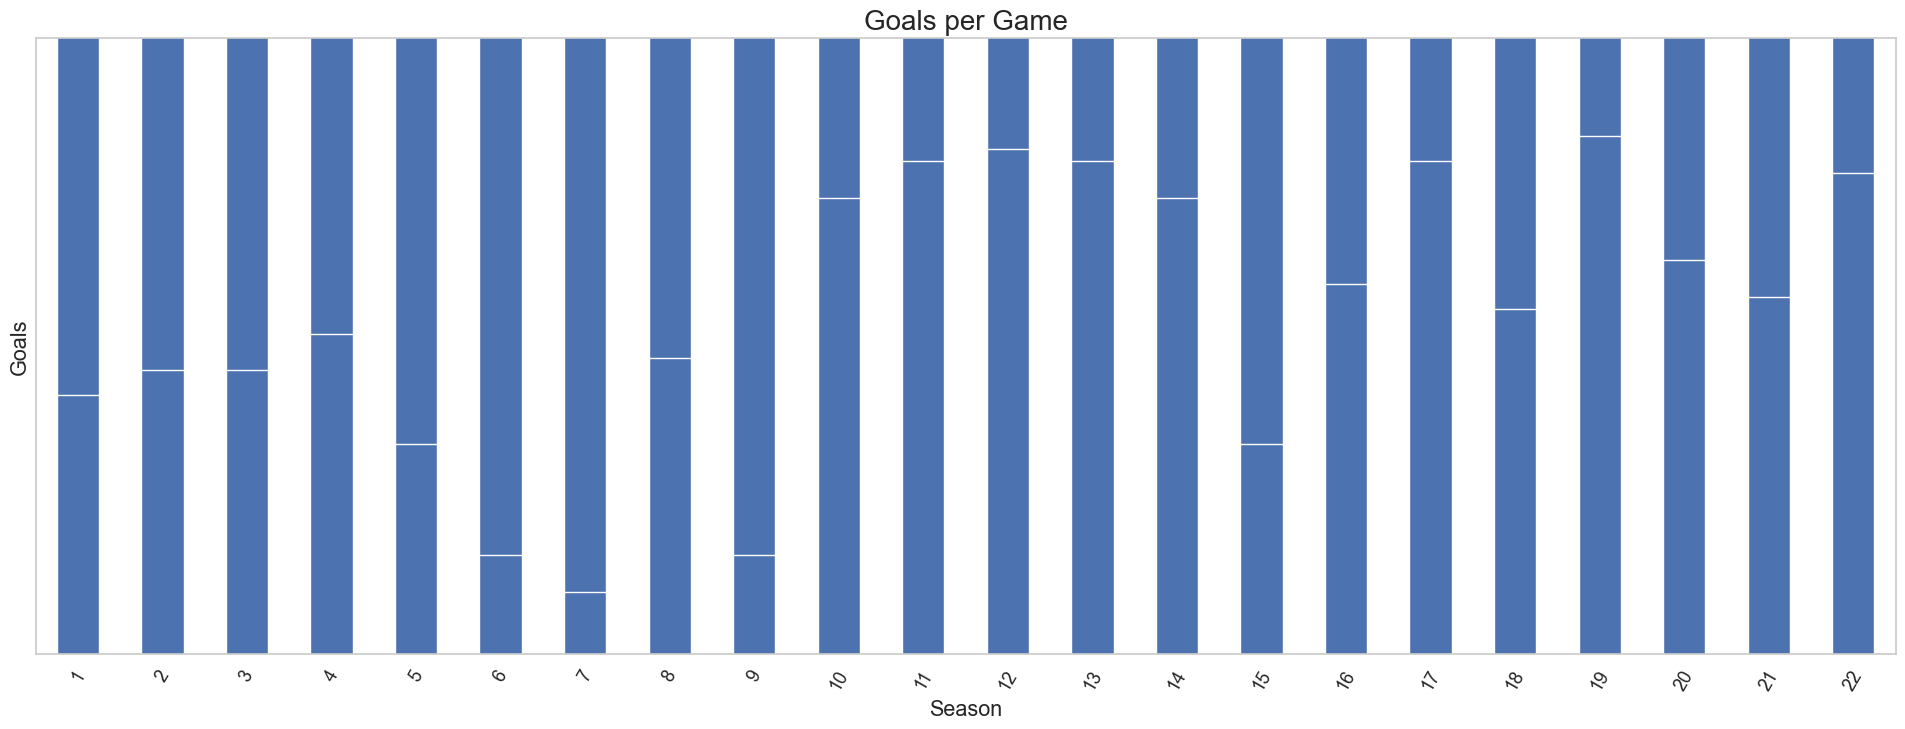

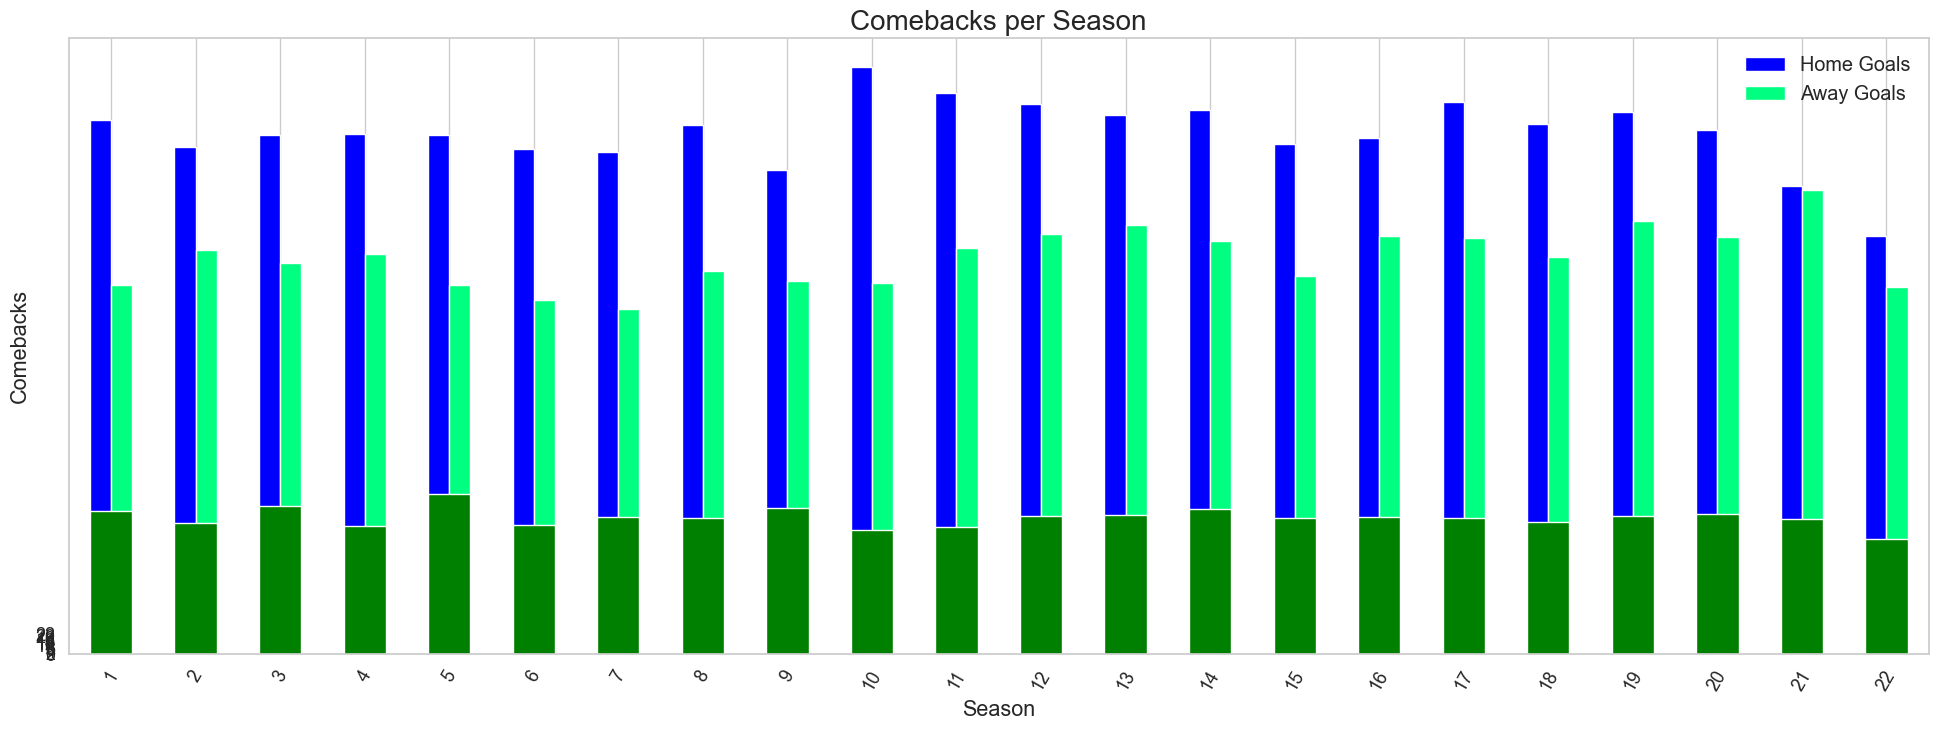

In [51]:
#=================== EDA
# Total Games Per Season
df.groupby('Season')['Season'].count().plot(kind='bar',fontsize=13,figsize=(16,7),yticks=np.arange(0,501,50))

plt.title("Matches Played per Season")
plt.xlabel("Season")
plt.ylabel("Matches")
plt.xticks(rotation=60)

# No. of Teams per season
df.groupby('Season')['HomeTeam'].nunique().plot(kind='bar',colormap='summer',fontsize=13,figsize=(16,7),yticks=np.arange(0, 26))
plt.ylabel('No. of Home Teams')
plt.title("Total No. of Teams per Season")
plt.xticks(rotation=60)

# Goals per Season
df['Total_Match_Goals'] = df['FTHG'] + df['FTAG']
df.groupby('Season')['Total_Match_Goals'].sum().plot(kind='bar',fontsize=13,figsize=(16,7),yticks=np.arange(0,1201,80)) 
plt.title("Goals Scored per Season")
plt.xlabel("Season")
plt.ylabel("Goals")
plt.xticks(rotation=60)

# Goals per Game in a Season
gpm = round(df.groupby('Season')['Total_Match_Goals'].sum()/df.groupby('Season')['Season'].count(),2)
gpm.plot(kind='bar',width=0.5,figsize=(24,8))

plt.grid(axis='y')
plt.ylim(2.4,2.9)  ##min value = 2.45 as seen in data [gpm.min()]
plt.ylabel('Goals')
plt.title("Goals per Game",fontsize=20)
plt.xticks(rotation=60)

# Distribution of Home and Away Team Goals per Season
df.groupby('Season')[['FTHG','FTAG']].sum().plot(kind='bar',fontsize=13,figsize=(24,8),yticks=np.arange(0,721,80),colormap='winter')
plt.grid(axis='y')
plt.ylabel('Goals')
plt.legend(['Home Goals','Away Goals'])
plt.title("Home Goals v/s Away Goals",fontsize=20)
plt.xticks(rotation=60)

# Ratio of Home Goals to Away Goals per Season
round((df.groupby('Season')['FTHG'].sum()/df.groupby('Season')['FTAG'].sum()),3).plot(kind='bar',figsize=(24,8),color='orange')
plt.grid(axis='y')
plt.ylabel("Ratio")
plt.title("Home Goals/Away Goals",fontsize= 20)
plt.xticks(rotation=60)

# Comebacks per Seaon
df['Comeback2']=np.where((df['FTR']!=df['HTR'])&(df['FTR']!='D') & (df['HTR']!='D'),1,0)

df.groupby('Season')['Comeback2'].sum().plot(kind='bar',figsize=(24,8),color='green',yticks=np.arange(0,23,2))
plt.grid(axis='y')
plt.title("Comebacks per Season",fontsize=20)
plt.ylabel('Comebacks')
plt.xticks(rotation=60)

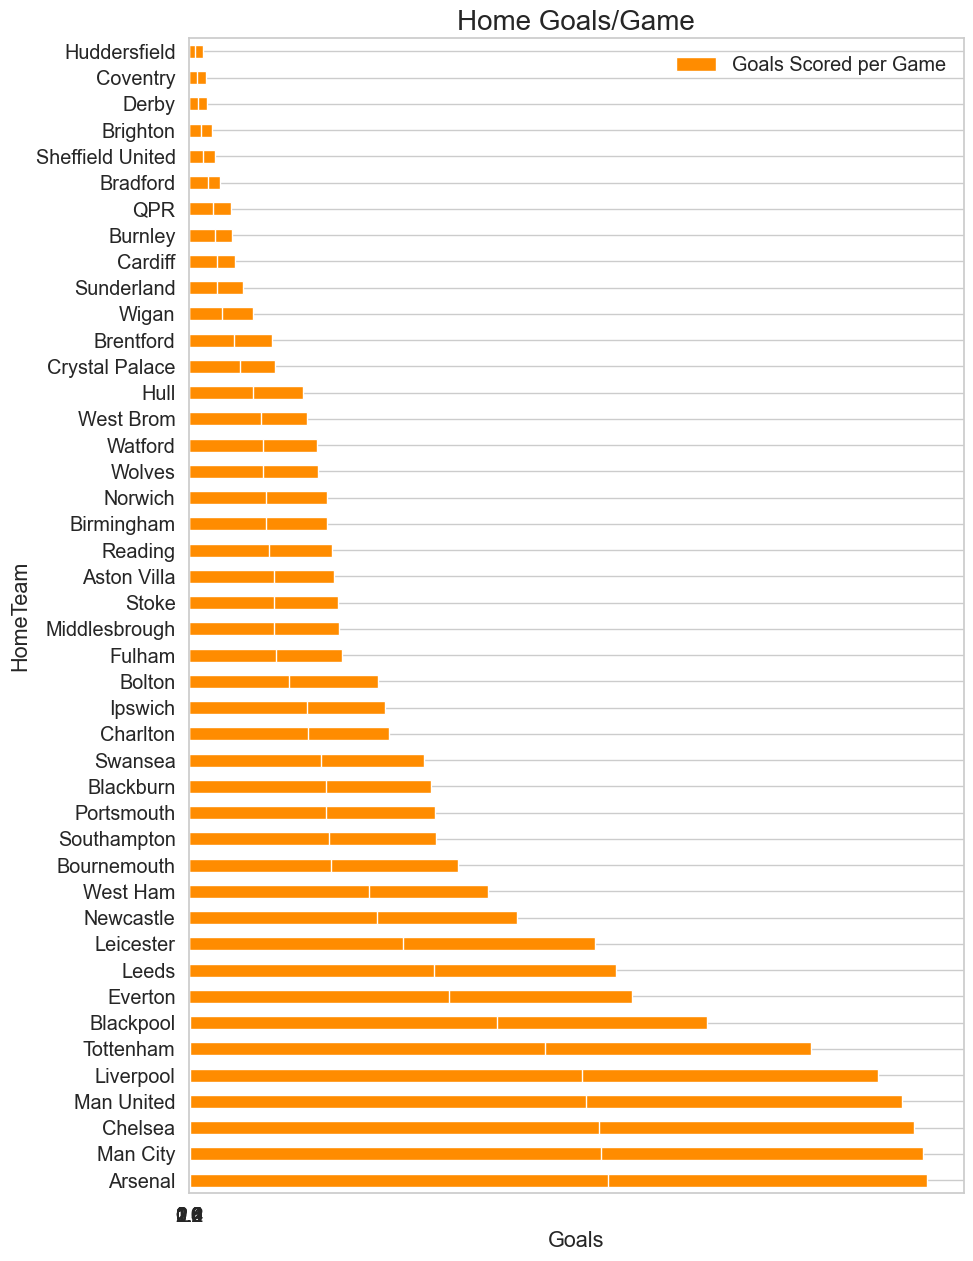

In [52]:
# Total Goals Scored by Each Team over all Seasons
tot_g = df.groupby('HomeTeam')['FTHG'].sum() + df.groupby('AwayTeam')['FTAG'].sum()
tot_g.sort_values(ascending=False).plot(kind='barh',figsize=(15,15),xticks=np.arange(0,1901,100),color='darkorange')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Total Goals by Teams",fontsize=20)

# Home Goals scored by Teams
df.groupby('HomeTeam')['FTHG'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(15,15),xticks=np.arange(0,1051,50),color='darkorange')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Home Goals by Teams",fontsize=20)
plt.legend(['Goals Scored'])

# Goals per Home Game
goals_h_game= round(df.groupby('HomeTeam')['FTHG'].sum()/df.groupby('HomeTeam')['HomeTeam'].count(),2)
goals_h_game.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,2.5,0.2),color='darkorange')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Home Goals/Game",fontsize=20)
plt.legend(['Goals Scored per Game'])

Text(0.5, 1.0, 'Home Ground Win %')

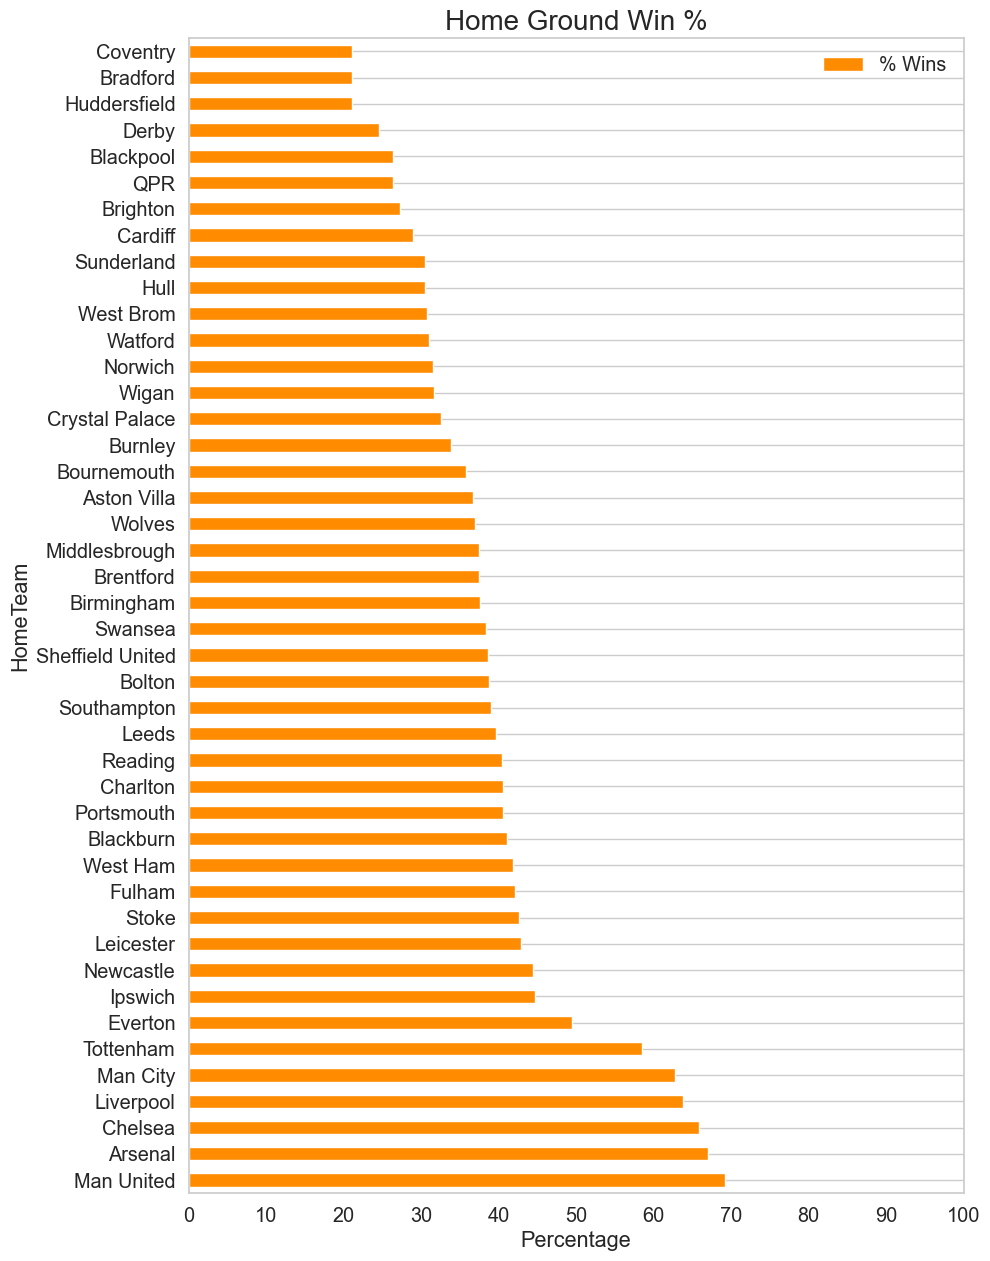

In [54]:
# Home Win Percentage
home_win=100*round((df.loc[df['FTR']==1].groupby('HomeTeam')['FTR'].count()/df.groupby('HomeTeam')['FTR'].count()),3)
home_win.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='darkorange')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Wins'])
plt.title("Home Ground Win %",fontsize=20)


Text(0.5, 1.0, 'Home Ground Loss %')

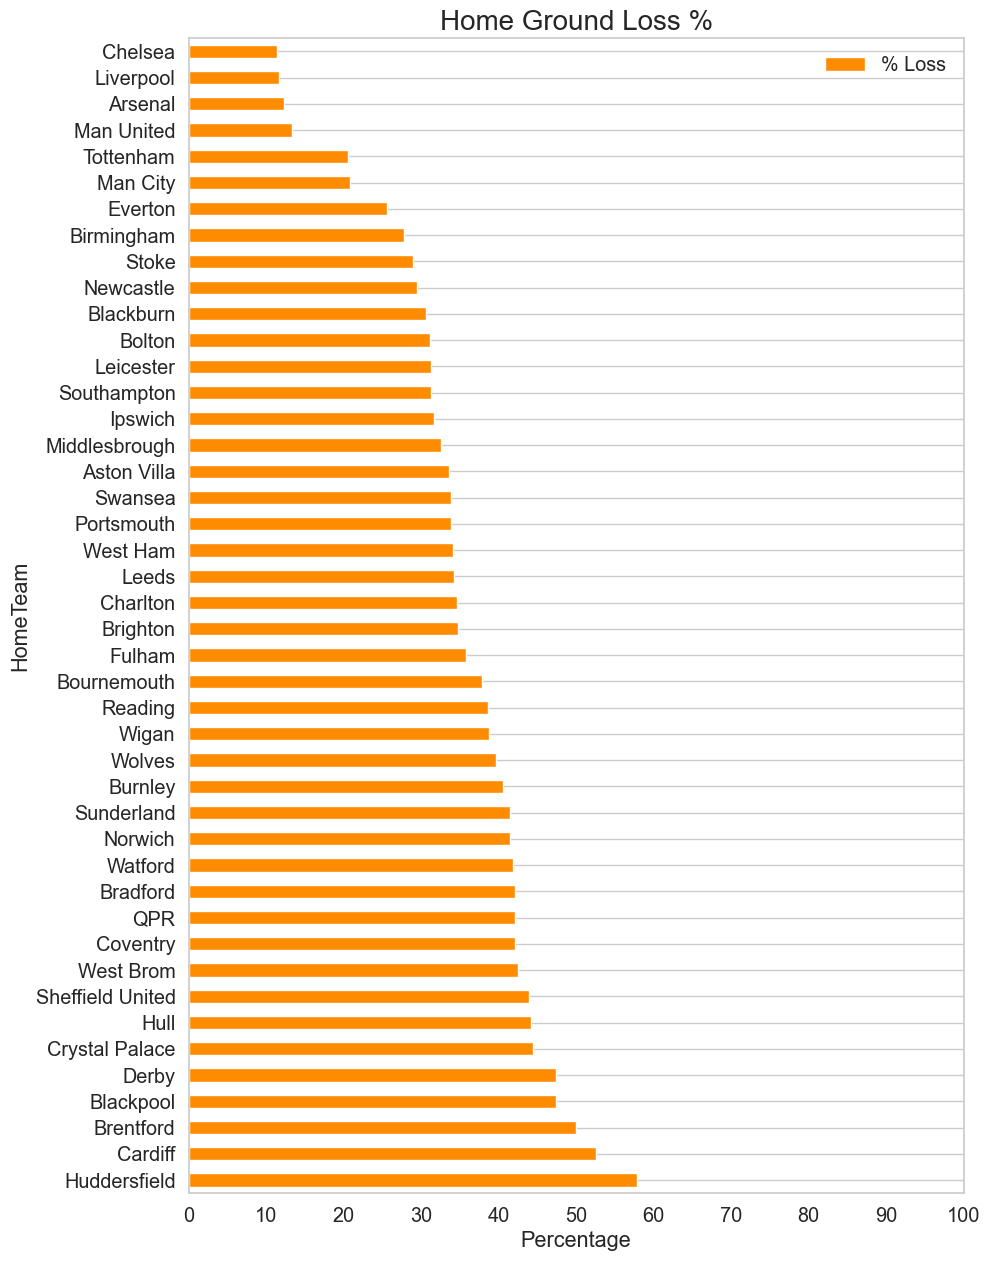

In [55]:

# Home Loss Percentage
home_loss=100*round((df.loc[df['FTR']==-1].groupby('HomeTeam')['FTR'].count()/df.groupby('HomeTeam')['FTR'].count()),3)
home_loss.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='darkorange')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Loss'])
plt.title("Home Ground Loss %",fontsize=20)



Text(0.5, 1.0, 'Home Ground Draw %')

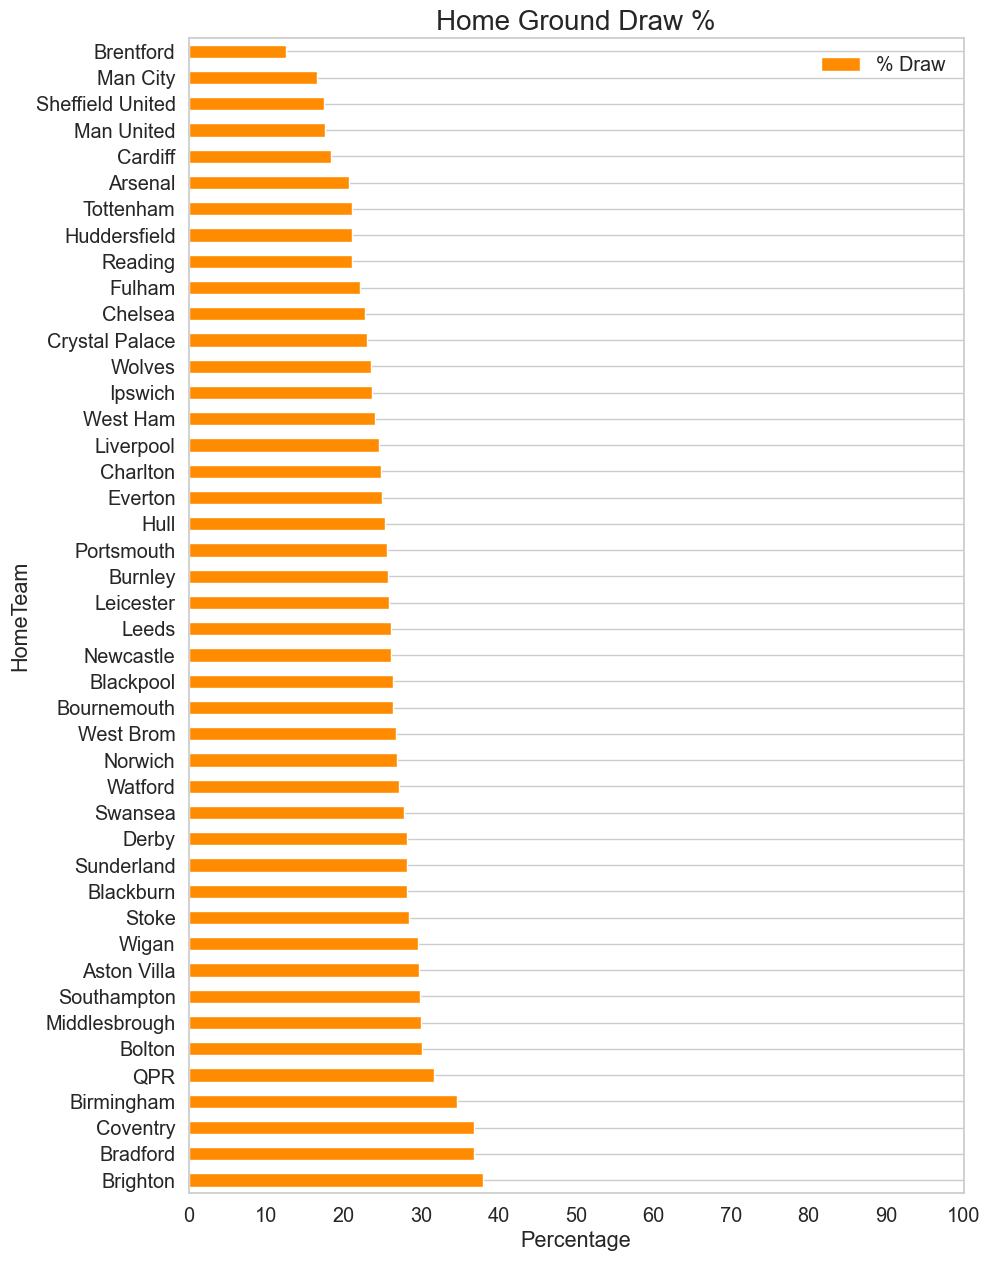

In [56]:
# Home Draw Percentage
home_draw=100*round((df.loc[df['FTR']==0].groupby('HomeTeam')['FTR'].count()/df.groupby('HomeTeam')['FTR'].count()),3)
home_draw.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='darkorange')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Draw'])
plt.title("Home Ground Draw %",fontsize=20)


Text(0.5, 1.0, 'Home Comebacks')

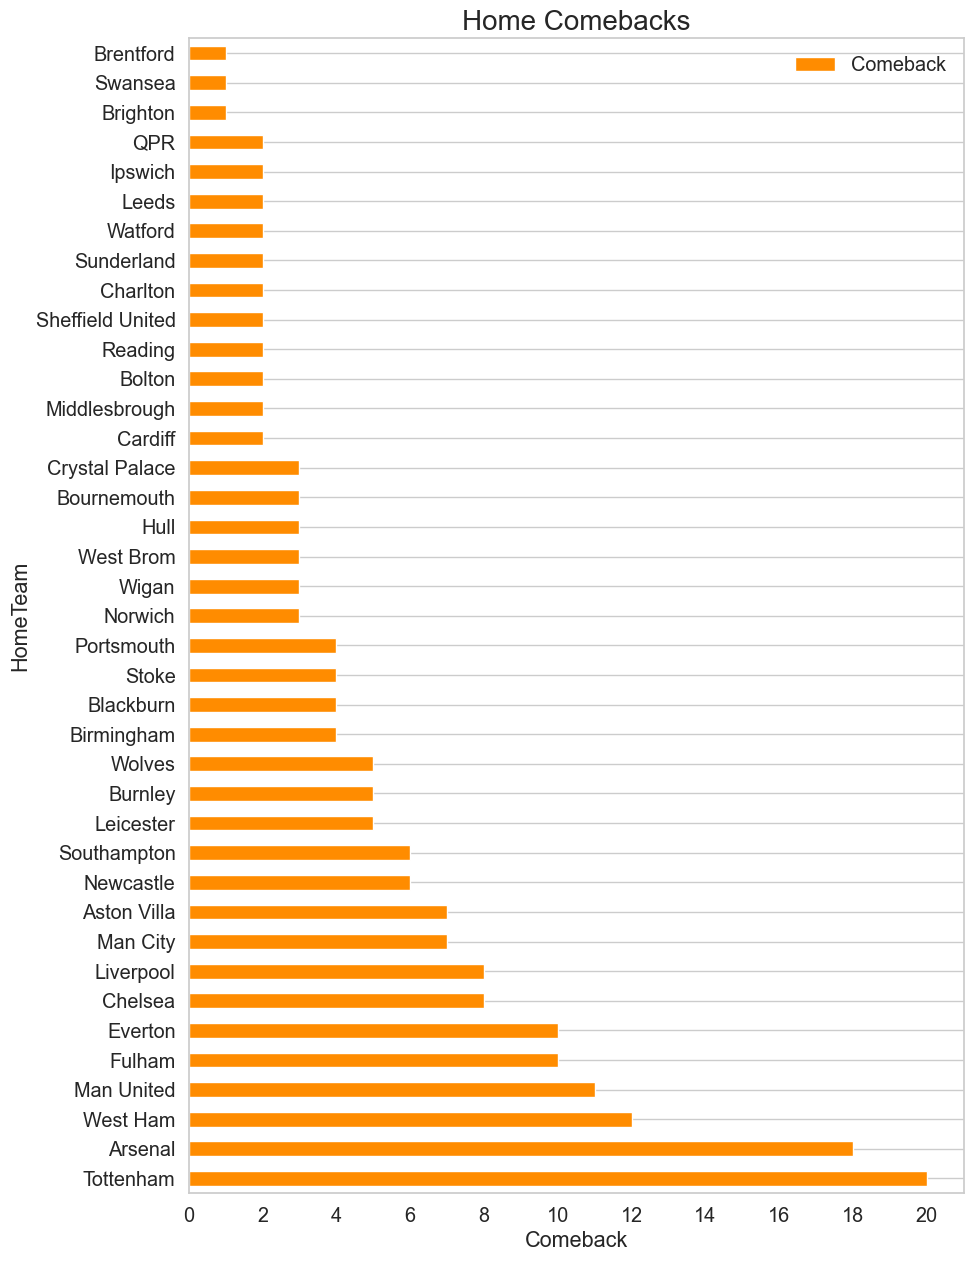

In [57]:

# Home ComeBack Percentage
home_cb = df.loc[(df['comeback']==1)].groupby('HomeTeam')['Comeback2'].sum()
home_cb.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,21,2),color='darkorange')
plt.grid(axis='x')
plt.xlabel('Comeback')
plt.legend(['Comeback'])
plt.title("Home Comebacks",fontsize=20)

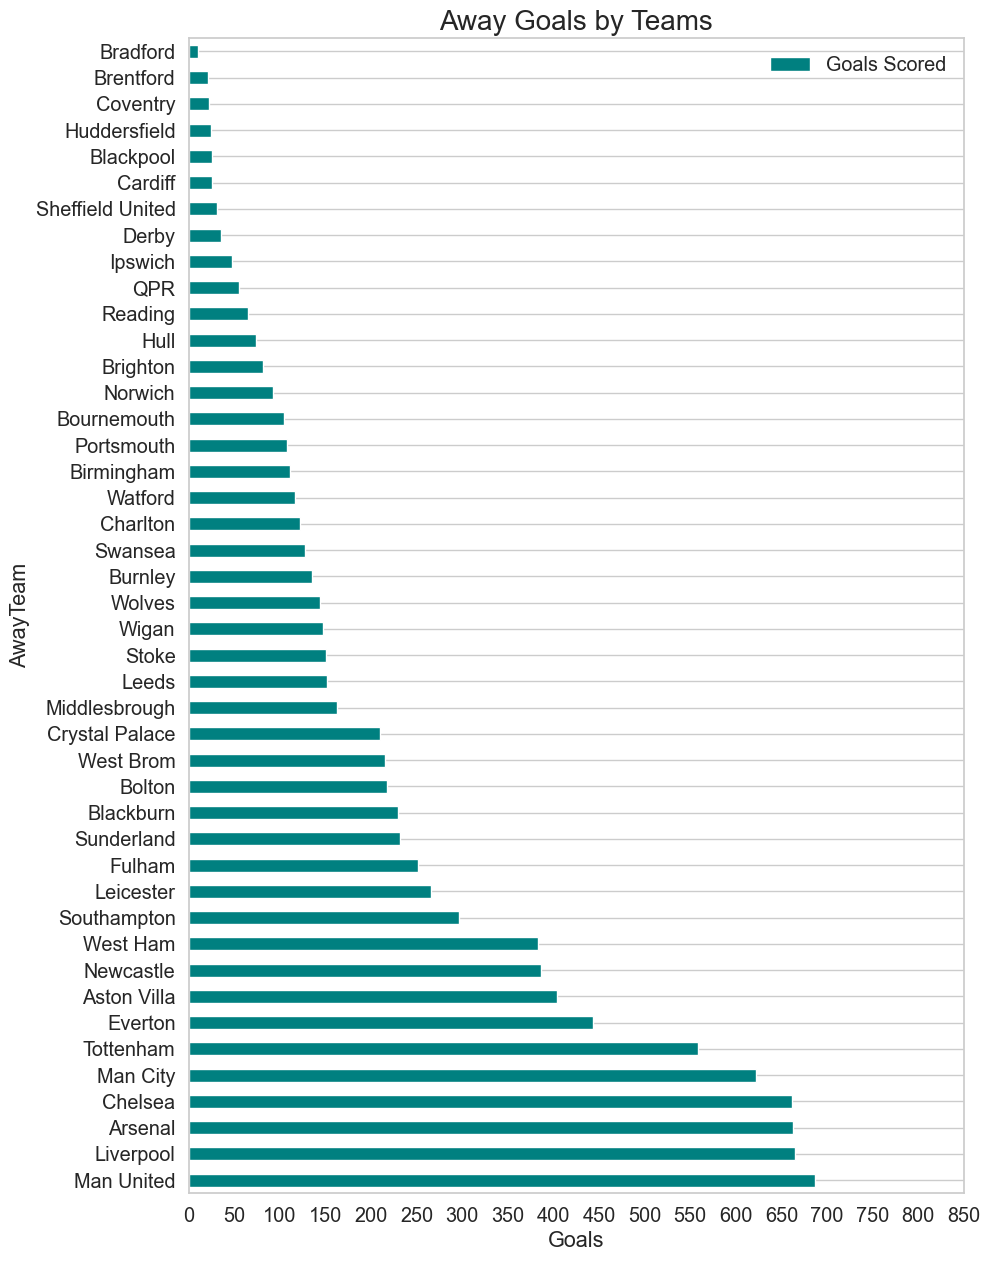

In [58]:
# Away Goals scored by Teams
df.groupby('AwayTeam')['FTAG'].sum().sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,851,50),color='teal')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Away Goals by Teams",fontsize=20)
plt.legend(['Goals Scored'])

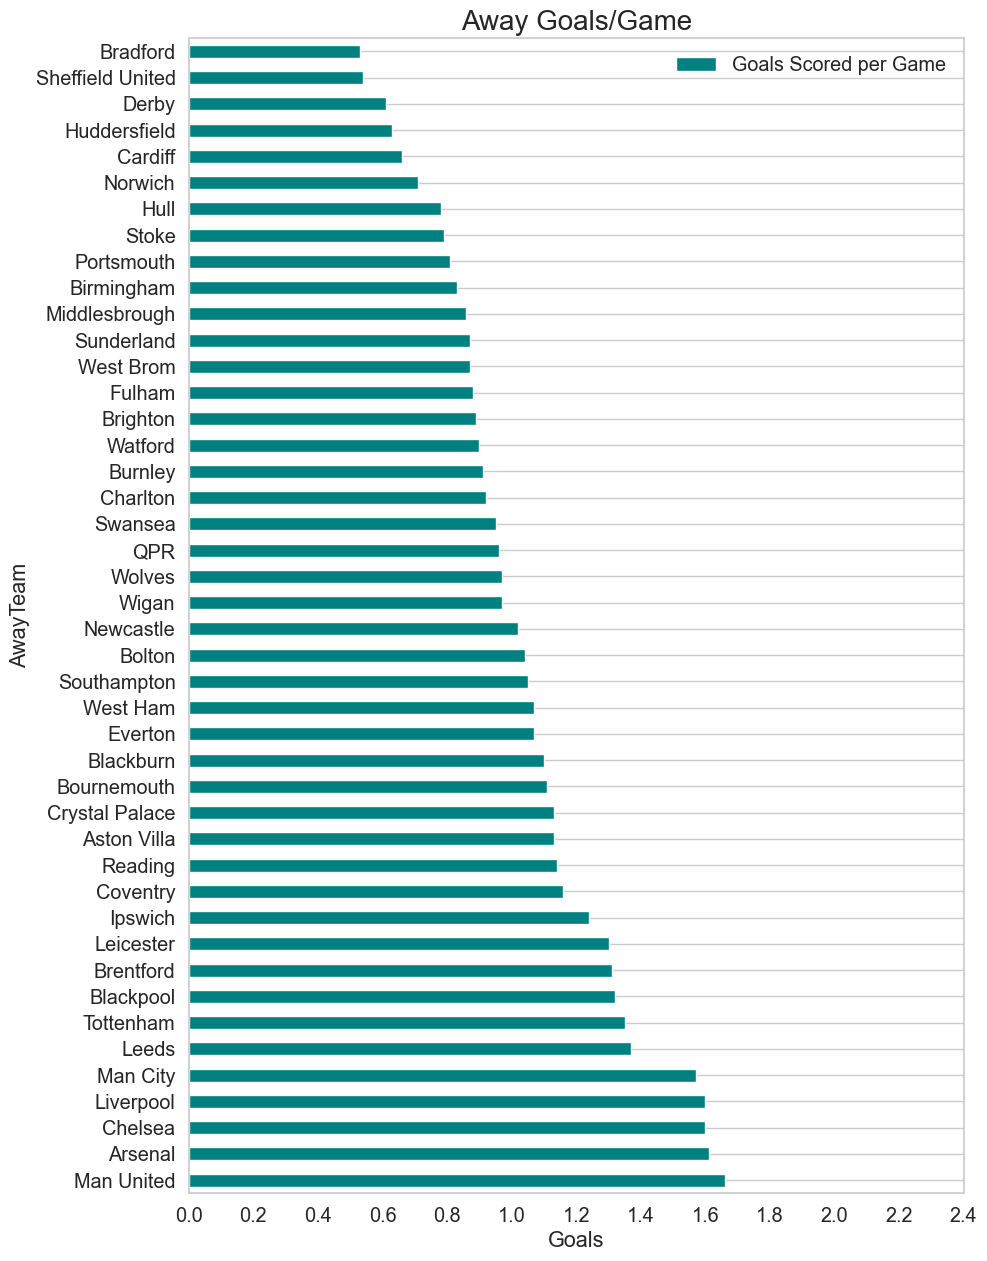

In [59]:
# Goals per Away Game
goals_a_game= round(df.groupby('AwayTeam')['FTAG'].sum()/df.groupby('AwayTeam')['AwayTeam'].count(),2)
goals_a_game.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,2.5,0.2),color='teal')
plt.grid(axis='x')
plt.xlabel("Goals")
plt.title("Away Goals/Game",fontsize=20)
plt.legend(['Goals Scored per Game'])

Text(0.5, 1.0, 'Away Ground Win %')

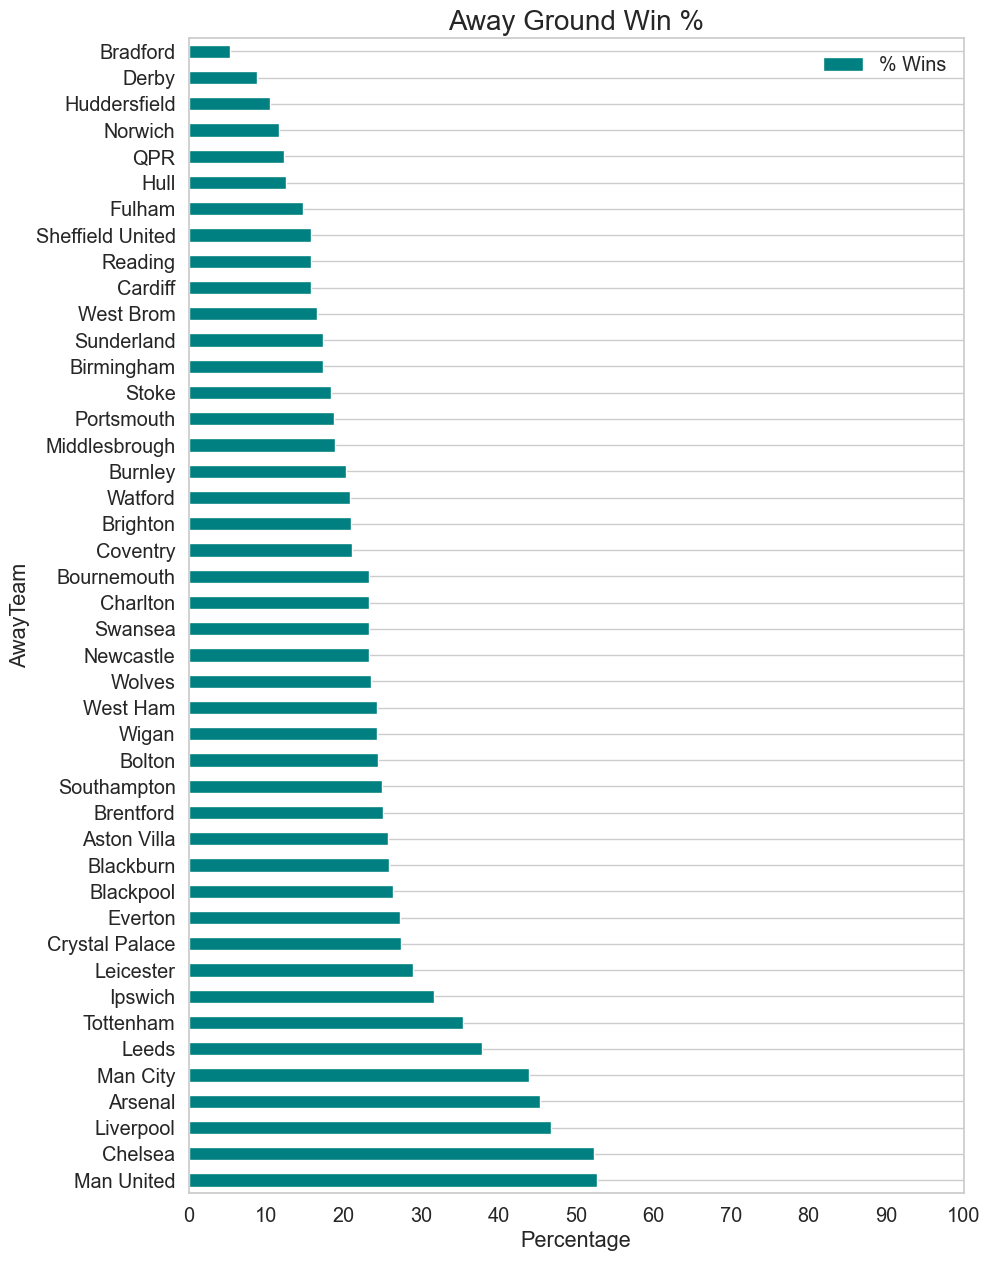

In [60]:
# Away Win Percentage
away_win=100*round((df.loc[df['FTR']==-1].groupby('AwayTeam')['FTR'].count()/df.groupby('AwayTeam')['FTR'].count()),3)
away_win.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Wins'])
plt.title("Away Ground Win %",fontsize=20)

Text(0.5, 1.0, 'Away Ground Loss %')

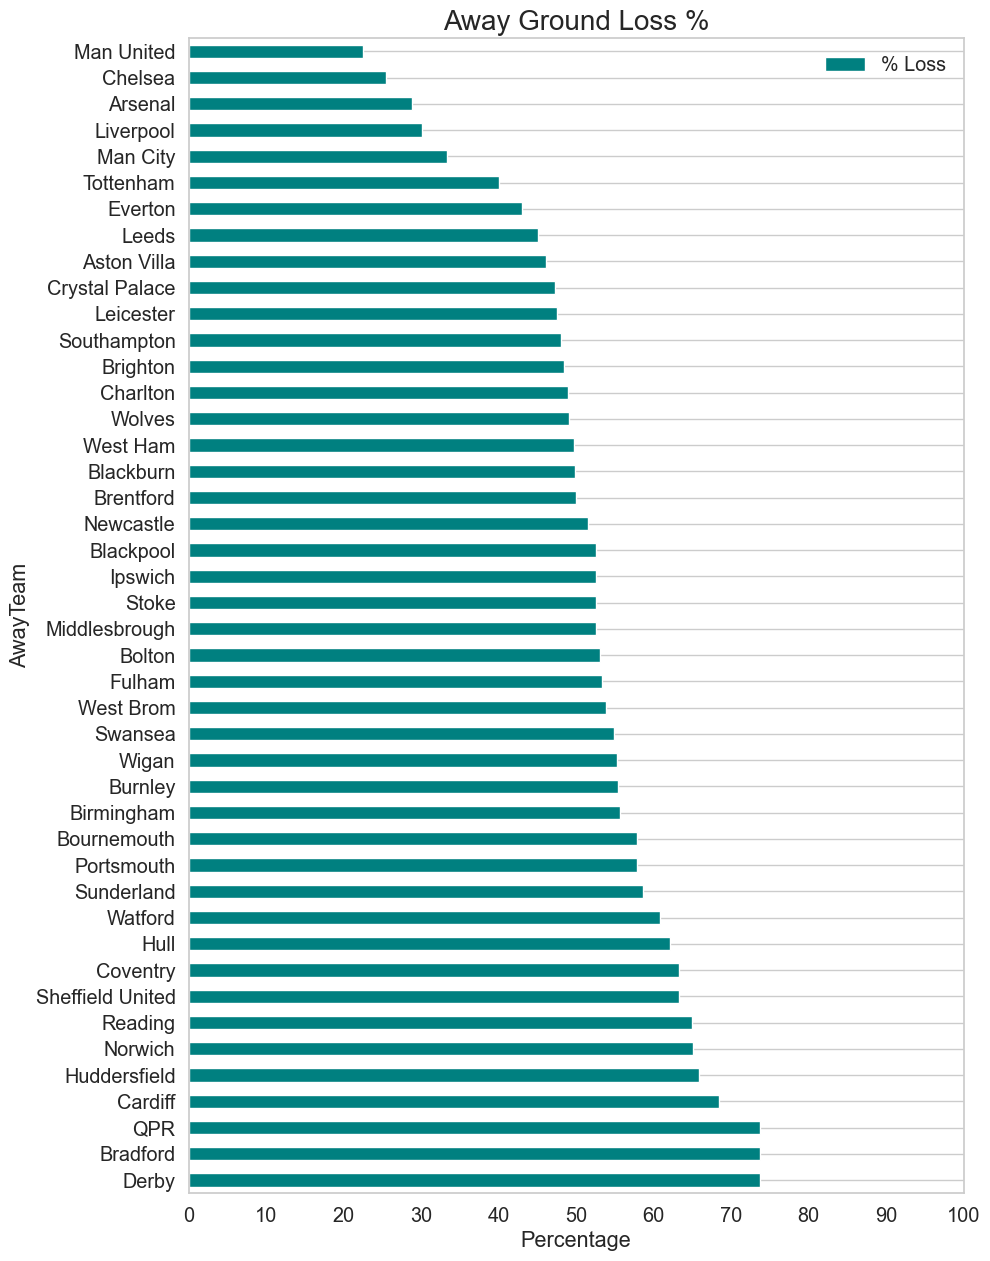

In [61]:
# Away Loss Percentage
away_loss=100*round((df.loc[df['FTR']==1].groupby('AwayTeam')['FTR'].count()/df.groupby('AwayTeam')['FTR'].count()),3)
away_loss.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Loss'])
plt.title("Away Ground Loss %",fontsize=20)

Text(0.5, 1.0, 'Away Ground Draw %')

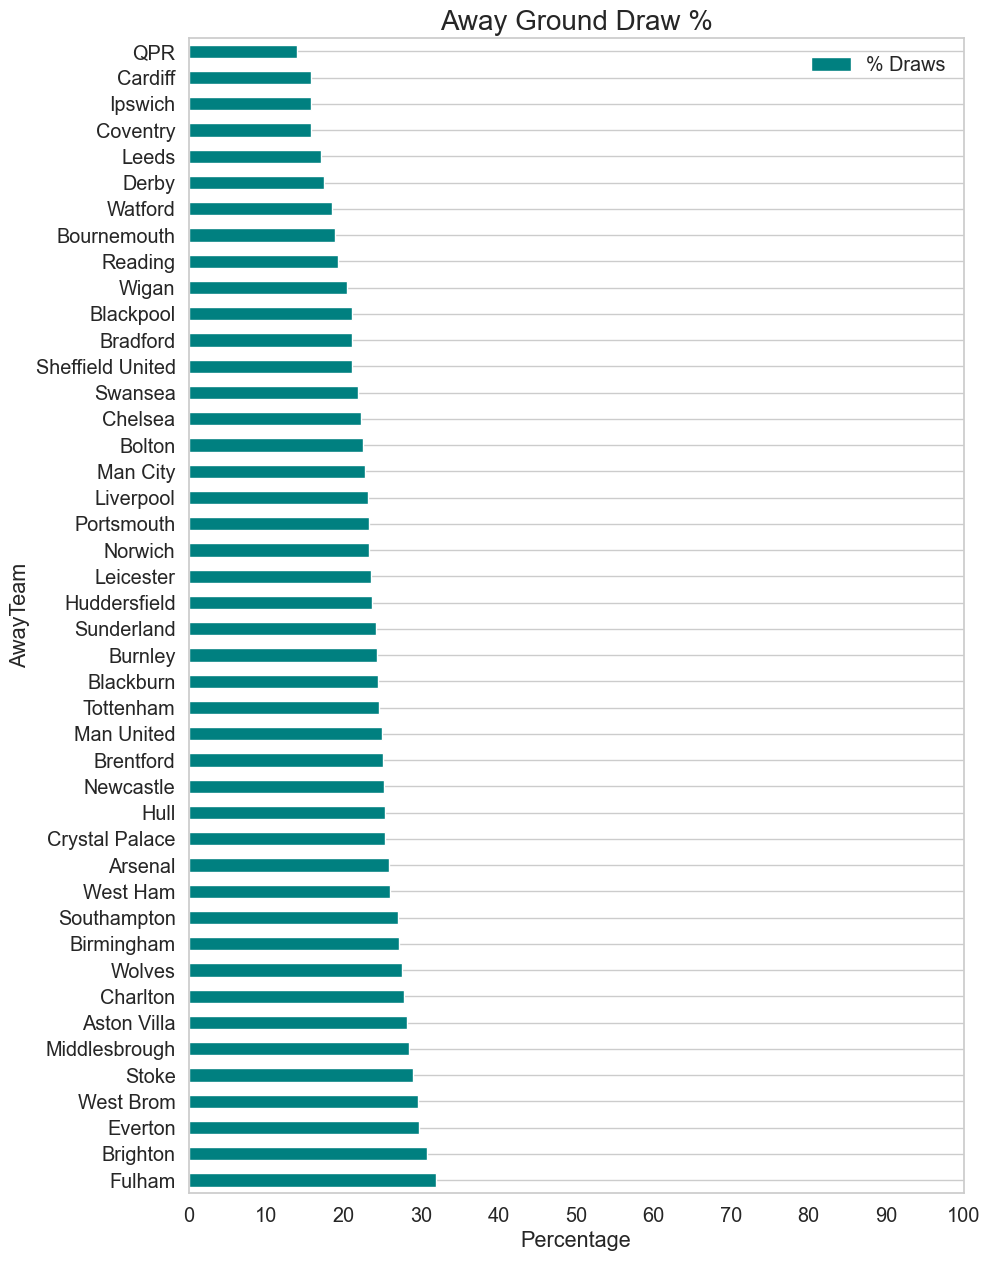

In [62]:
# Away Draw Percentage
away_draw=100*round((df.loc[df['FTR']==0].groupby('AwayTeam')['FTR'].count()/df.groupby('AwayTeam')['FTR'].count()),3)
away_draw.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,101,10),color='teal')
plt.grid(axis='x')
plt.xlabel('Percentage')
plt.legend(['% Draws'])
plt.title("Away Ground Draw %",fontsize=20)

Text(0.5, 1.0, 'Away Comebacks')

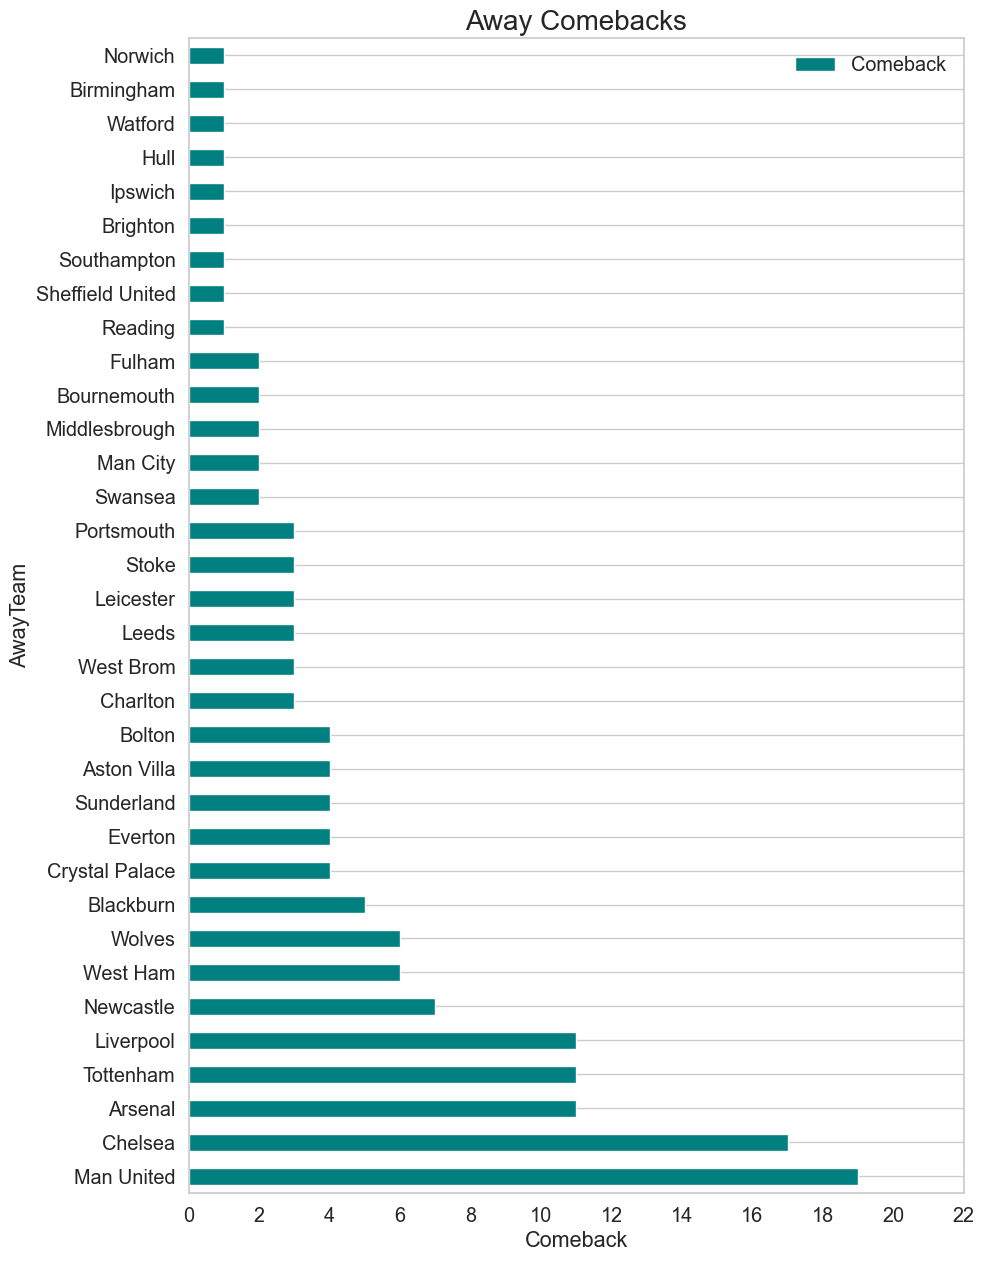

In [63]:
# Away ComeBack Percentage
away_cb = df.loc[(df['comeback']==-1)].groupby('AwayTeam')['Comeback2'].sum()
away_cb.sort_values(ascending=False).plot(kind='barh',figsize=(10,15),xticks=np.arange(0,23,2),color='teal')
plt.grid(axis='x')
plt.xlabel('Comeback')
plt.legend(['Comeback'])
plt.title("Away Comebacks",fontsize=20)

Text(0.5, 1.0, 'Home/Total Comebacks')

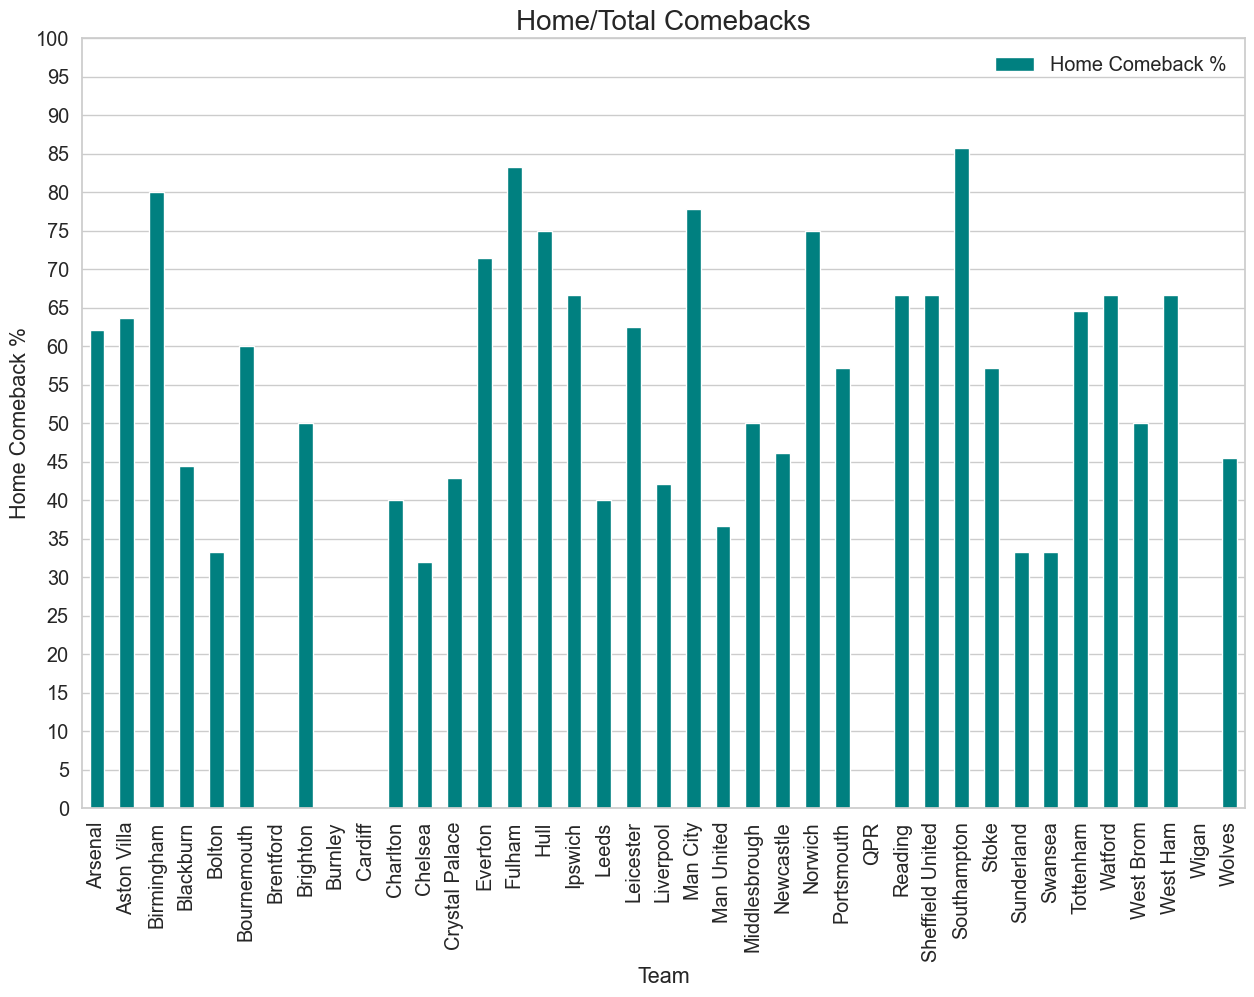

In [64]:
# Home and Away Comeback Percentage
(100*(home_cb/(home_cb+away_cb))).plot(kind='bar',figsize=(15,10),yticks=np.arange(0,101,5),color='teal')
plt.grid(axis='x')
plt.xlabel('Team')
plt.ylabel('Home Comeback %')
plt.legend(['Home Comeback %'])
plt.title("Home/Total Comebacks",fontsize=20)

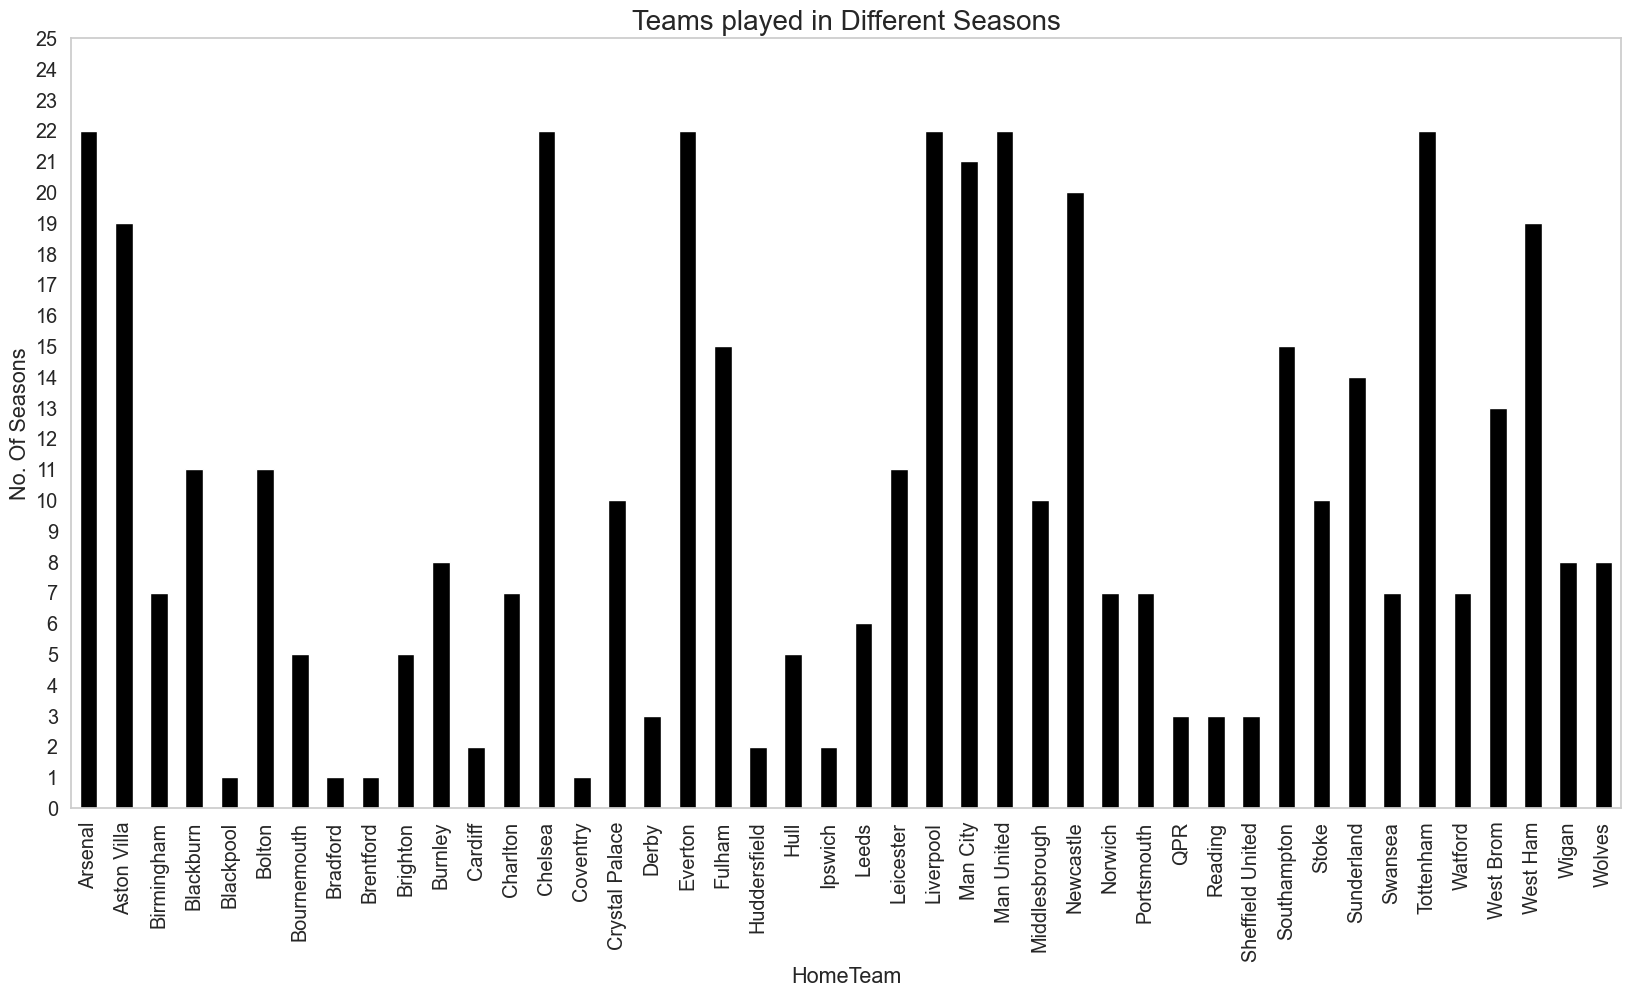

In [65]:
# Teams have played in Different Seasons
df.groupby(['HomeTeam'])['Season'].nunique().plot(kind='bar',figsize=(20,10),yticks=np.arange(0,26,1),color='black')
plt.ylabel("No. Of Seasons")
plt.xticks(rotation=90)
plt.title("Teams played in Different Seasons",fontsize=20)
plt.grid()